In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
datapath = "data/"

In [3]:
def get_normalization_params(dataset_name, datapath):
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
        # the mean of each pixel
        means = train_dataset.data.mean(axis=(0,1,2)) / 255.0
        # mean of the stds of each pixel across the channels
        stds = train_dataset.data.std(axis=(1,2)).mean(axis=0) / 255.0
        
    elif dataset_name == "cifar100":
        train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
        # the mean of each pixel
        means = train_dataset.data.mean(axis=(0,1,2)) / 255.0
        # the std of each pixel
        stds = train_dataset.data.std(axis=(0,1,2)) / 255.0
    elif dataset_name == "clothing1m":
        pass
    else:
        raise Exception

    return means, stds

In [4]:
def assert_dataset_name_and_noise_mode_combos(dataset_name, noise_mode):
    cifar10_sym_condition = dataset_name == "cifar10" and noise_mode == "sym"
    cifar10_asym_condition = dataset_name == "cifar10" and noise_mode == "asym"
    cifar100_sym_condition = dataset_name == "cifar100" and noise_mode == "sym"
    cifar100_asym_condition = dataset_name == "cifar100" and noise_mode == "asym"
    cifar10_dependent_condition = dataset_name == "cifar10" and noise_mode == "dependent"
    cifar100_dependent_condition = dataset_name == "cifar100" and noise_mode == "dependent"
    cifar10_openset_condition = dataset_name == "cifar10" and noise_mode == "openset"
    
    assert (
        cifar10_sym_condition or cifar10_asym_condition or \
        cifar100_sym_condition or cifar100_asym_condition or \
        cifar10_dependent_condition or cifar100_dependent_condition or \
        cifar10_openset_condition
    )
    

def make_inherent_label_noise(datapath, dataset_name, noise_mode, p, seed=None):
    # check combos
    assert_dataset_name_and_noise_mode_combos(dataset_name=dataset_name, noise_mode=noise_mode)
    
    if noise_mode in ["sym", "asym"]:
        kwargs = make_inherent_label_noise_sym_asym(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=seed)
    elif noise_mode == "openset":
        kwargs = make_inherent_label_noise_openset(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=seed)
    elif noise_mode == "dependent":
        kwargs = make_inherent_label_noise_dependent(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=None)
    else:
        raise Exception
        
    return kwargs
    
def make_inherent_label_noise_openset(datapath, dataset_name, noise_mode, p, seed=None):
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    else:
        raise Exception
    
    #p = 0.4
    noise_rules = make_openset_noise_rules(dataset_name=dataset_name, p=p)
    train_openset_dataset_data = np.copy(train_dataset.data)
    indices_set = set()
    
    # only one noise rule for now
    for noise_rule in noise_rules:
        indices_per_rule, openset_data_per_rule = \
            make_openset_noise(train_dataset=train_dataset, src=noise_rule["src"], dst=noise_rule["dst"], p=noise_rule["p"], seed=seed)
        indices_set.update(list(indices_per_rule))
        train_openset_dataset_data[indices_per_rule] = openset_data_per_rule
    
    indices = list(indices_set)
    labels_noisy = np.array([False for i in range(len(train_dataset))])    
    labels_noisy[indices] = True

    labels_df = pd.DataFrame(data={"label": train_dataset.targets, "label_noisy": labels_noisy})
    labels_csv_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_custom.csv" 
    labels_df.to_csv(labels_csv_path, index=False)
    print(f"{labels_csv_path} generated\n")
    
    noise_rules_df = pd.DataFrame(data=noise_rules)
    noise_rules_csv_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_noise_rules.csv"
    noise_rules_df.to_csv(noise_rules_csv_path, index=False)
    print(f"{noise_rules_csv_path} generated\n")
    
    dataset_data_npy_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_custom.npy"
    np.save(dataset_data_npy_path, train_openset_dataset_data)
    print(f"{dataset_data_npy_path} generated\n")
    
    kwargs = {
        "labels_csv_path": labels_csv_path,
        "noise_rules_csv_path": noise_rules_csv_path,
        "dataset_data_npy_path": dataset_data_npy_path,
    }
    
    return kwargs

def make_inherent_label_noise_dependent(datapath, dataset_name, noise_mode, p, seed=None):
    raise NotImplementedError
    
    return kwargs
    
def make_inherent_label_noise_sym_asym(datapath, dataset_name, noise_mode, p, seed=None):   
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    elif dataset_name == "cifar100":
        train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    else:
        raise Exception
    
    if noise_mode == "sym":
        #p = 0.4
        noise_rules = make_sym_noise_rules(dataset_name=dataset_name, train_dataset=train_dataset, p=p)
    elif noise_mode == "asym":
        #p = 0.4
        noise_rules = make_asym_noise_rules(dataset_name=dataset_name, train_dataset=train_dataset, p=p)
    else:
        raise Exception
    
    targets = torch.tensor(train_dataset.targets)
    noisy_targets = targets.detach().clone()

    for noise_rule in noise_rules:
        #indices_per_rule, dirty_indicator_indices_per_rule, noisy_targets_per_rule = \
        #    make_sym_asym_noise(train_dataset=train_dataset, src=noise_rule["src"], dsts=noise_rule["dsts"], p=noise_rule["p"], seed=seed)
        #noisy_targets[indices_per_rule] = noisy_targets_per_rule[indices_per_rule]
        
        indices_per_rule, noisy_targets_per_rule = \
            make_sym_asym_noise(train_dataset=train_dataset, src=noise_rule["src"], dsts=noise_rule["dsts"], p=noise_rule["p"], seed=seed)
        noisy_targets[indices_per_rule] = noisy_targets_per_rule
        

    labels_df = pd.DataFrame(data={"label": targets.numpy(), "label_noisy": noisy_targets.numpy()})
    labels_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.csv"
    labels_df.to_csv(labels_csv_path, index=False)
    print(f"{labels_csv_path} generated\n")
    #print(torch.where(targets != noisy_targets)[0])
    #print(torch.where(targets != noisy_targets)[0].size(dim=0) / targets.size(dim=0))
    
    noise_rules_df = pd.DataFrame(data=noise_rules)
    noise_rules_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_noise_rules.csv"
    noise_rules_df.to_csv(noise_rules_csv_path, index=False)
    print(f"{noise_rules_csv_path} generated\n")
    
    kwargs = {
        "labels_csv_path": labels_csv_path,
        "noise_rules_csv_path": noise_rules_csv_path
    }
    
    return kwargs
        
    
def make_sym_asym_noise(train_dataset, src, dsts, p, seed=None):
    # set seed for reprodcuibility
    if seed is not None:
        torch.manual_seed(seed)
    
    # clean targets
    targets = torch.tensor(train_dataset.targets)
    # copy clean targets to noisy targets
    #noisy_targets = targets.detach().clone()

    # get all labels
    labels = torch.tensor(list(train_dataset.class_to_idx.values()))
    labels_len = torch.tensor(labels.size(dim=0))

    # get src targets indices (indices in all dataset)
    # asym: get indices of src targets
    indices = torch.where(targets == train_dataset.class_to_idx[src])[0]

    # p_mask eg 0.4 for each src target, each target flips with probability p
    p_mask = torch.ones_like(targets[indices]) * p
    # flip_mask is 0s and 1s  (flip is 1s)
    flip_mask = torch.bernoulli(input=p_mask)

    # keep_mask is inverse of flip_mask (keep is 1s)
    keep_mask = (flip_mask * (-1)) + 1

    # p_mask_label is dst label probability distribution to flip to (length is number of classes), sums to 1.0
    # asym: dst class is 1.0, all else 0.0
    p_mask_label = torch.zeros_like(labels, dtype=torch.float)

    p_mask_label[[train_dataset.class_to_idx[dst] for dst in dsts]] = 1.0 / len(dsts)

    # flip_mask_label is categorical distribution with params p_mask_label for each dst class
    flip_mask_label = torch.distributions.categorical.Categorical(p_mask_label)

    # flipped_targets is dst labels for each src label that the src label can flip to
    # for now, only one dst, so all in flip_targets is dst class label
    flipped_targets = flip_mask_label.sample(sample_shape=targets[indices].shape)

    # mask the flipped_targets to get the actually flipped instances (ones not to be flipped are 0s, ones to be flipped are dst labels)
    masked_flipped_targets = flipped_targets * flip_mask

    # mask the actual targets to keep the ones not flipped (ones not to be flipped are original labels, ones to be flipped are 0s)
    masked_targets = targets[indices] * keep_mask

    # add vectors together - kept ones remain, flipped ones are flipped
    noisy_targets_sub = (masked_targets + masked_flipped_targets).long()

    # insert into noisy_targets the flipped targets
    #noisy_targets[indices] = noisy_targets_sub

    # get the indices of the noisy instances (indices in all dataset)
    #dirty_indicator_indices = torch.where(targets != noisy_targets)[0]
    
    #return indices, dirty_indicator_indices, noisy_targets
    return indices, noisy_targets_sub

def make_openset_noise(train_dataset, src, dst, p, seed=None):
    if dst == "cifar100":
        dst_dataset = datasets.CIFAR100(os.path.join("data", "cifar100"), train=True, download=True)
    else:
        raise Exception
    
    if seed is not None:
        np.random.seed(seed)
    
    indices = np.random.choice(len(train_dataset), int(len(train_dataset) * p), replace=False)

    if seed is not None:
        np.random.seed(seed + 123)

    indices_dst = np.random.choice(len(train_dataset), int(len(train_dataset) * p), replace=False)
    openset_data = dst_dataset.data[indices_dst]
    
    assert train_dataset.data[indices].shape == openset_data.shape
    
    return indices, openset_data

In [5]:
def make_sym_noise_rules(dataset_name, train_dataset, p=0.4):
    if dataset_name in ["cifar10", "cifar100"]:
        labels = list(train_dataset.class_to_idx.keys())
        noise_rules = []

        for src in labels:
            dsts = labels.copy()
            dsts.remove(src)

            noise_rule = {"src":src, "dsts":dsts, "p":p}
            noise_rules.append(noise_rule)

    else:
        raise Exception
        
    return noise_rules

def make_asym_noise_rules(dataset_name, train_dataset, p=0.4):
    if dataset_name == "cifar10":
        noise_rules = [
            {"src":"truck", "dsts":["automobile"], "p":p},
            {"src":"bird", "dsts":["airplane"], "p":p},
            {"src":"cat", "dsts":["dog"], "p":p},
            {"src":"dog", "dsts":["cat"], "p":p}
        ]

    elif "cifar100":
        labels = np.array(list(train_dataset.class_to_idx.keys()))
        labels_shifted = np.roll(labels, 1)
        noise_rules = []
        for src, dst in zip(labels_shifted, labels):
            noise_rule = {"src":src, "dsts":[dst], "p":p}
            noise_rules.append(noise_rule)
    else:
        raise Exception
        
    return noise_rules

def make_openset_noise_rules(dataset_name, p=0.4):
    if dataset_name == "cifar10":
        noise_rules = [{"src": dataset_name, "dst": "cifar100", "p": p}]
    else:
        raise Exception
        
    return noise_rules

In [6]:
def add_inherent_label_noise(train_dataset, datapath, dataset_name, noise_mode, p, custom):
    assert_dataset_name_and_noise_mode_combos(dataset_name, noise_mode)
    
    if noise_mode in ["sym", "asym"]:
        labels_csv_path = \
            f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.csv" if custom else f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}.csv"
        noise_rules_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_noise_rules.csv"
        
        noise_rules = pd.read_csv(noise_rules_csv_path)
        targets_noisy = list(pd.read_csv(labels_csv_path)["label_noisy"].values.astype(int))
        
        targets = train_dataset.targets
        indices_noisy = np.array([targets[i] != targets_noisy[i] for i in range(len(targets_noisy))])
        train_dataset.targets = targets_noisy
        
        print(f"adding inherent noise to {dataset_name}: {'custom' if custom else 'from paper'}, noise_mode:{noise_mode}, p:{p}")
        print(f"labels_csv_path:{labels_csv_path}, noise_rules_csv_path:{noise_rules_csv_path}")
        
    elif noise_mode == "openset" and custom:
        labels_csv_path = \
            f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.csv"
        noise_rules_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_noise_rules.csv"
        dataset_data_npy_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.npy"
        
        noise_rules = pd.read_csv(noise_rules_csv_path)
        indices_noisy = pd.read_csv(labels_csv_path)["label_noisy"].values.astype(bool)
        train_dataset_data = np.load(dataset_data_npy_path)
        
        train_dataset.data = train_dataset_data.copy()
        
        print(f"adding inherent noise to {dataset_name}: {'custom' if custom else 'from paper'}, noise_mode:{noise_mode}, p:{p}")
        print(f"labels_csv_path:{labels_csv_path}, noise_rules_csv_path:{noise_rules_csv_path}, dataset_data_npy_path:{dataset_data_npy_path}")
        
    elif noise_mode == "dependent" and not custom:
        labels_csv_path = \
            f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}.csv"
        noise_rules_csv_path = None
        
        noise_rules = None
        targets_noisy = list(pd.read_csv(labels_csv_path)["label_noisy"].values.astype(int))
        
        targets = train_dataset.targets
        indices_noisy = np.array([targets[i] != targets_noisy[i] for i in range(len(targets_noisy))])
        train_dataset.targets = targets_noisy
        
        print(f"adding inherent noise to {dataset_name}: {'custom' if custom else 'from paper'}, noise_mode:{noise_mode}, p:{p}")
        print(f"labels_csv_path:{labels_csv_path}, noise_rules_csv_path:{noise_rules_csv_path}")
    else:
        raise Exception
        
    return train_dataset, indices_noisy, noise_rules

In [7]:
def show_imgs(datapath, dataset_name, train_dataset, noise_mode, indices_noisy):
    
    class_to_idx_list=list(train_dataset.class_to_idx.keys())
    
    if dataset_name == "cifar10":
        train_dataset_viz = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    elif dataset_name == "cifar100":
        train_dataset_viz = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    
    targets_clean = train_dataset_viz.targets
    train_dataset_viz.targets = train_dataset.targets
    train_dataset_viz.data = train_dataset.data
    
    indices_noisy_args = np.argwhere(indices_noisy).flatten()
    indices_clean_args = np.argwhere(indices_noisy == False).flatten()
    
    figure = plt.figure(figsize=(8*3, 8))
    cols, rows = 4*2, 4
    half = int(cols * rows / 2)
    
    for i in range(1, cols * rows + 1):
        # noisy
        if half < i:
            sample_idx = np.random.choice(indices_noisy_args, 1, replace=False)[0]
        # clean
        else:
            sample_idx = np.random.choice(indices_clean_args, 1, replace=False)[0]
        
        img, label = train_dataset_viz[sample_idx]
        figure.add_subplot(rows, cols, i)
        
        # noisy
        if half < i:
            if noise_mode in ["sym", "asym", "dependent"]:
                plt.title(f"dirty:{class_to_idx_list[label]} ({class_to_idx_list[targets_clean[sample_idx]]})")
            elif noise_mode  == "openset":
                plt.title(f"dirty:({class_to_idx_list[label]})")
        # clean
        else:
            plt.title(f"clean:{class_to_idx_list[label]}")
            
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    
    plt.show()

In [8]:
def check_combos(dataset_name, noise_mode, custom_noise):
    cond_fail_1 = custom_noise and dataset_name in ["cifar10", "cifar100"] and noise_mode == "dependent"
    cond_fail_2 = dataset_name == "cifar100" and noise_mode == "openset"
    cond_fail = cond_fail_1 or cond_fail_2
    assert not cond_fail, f"Incorrect combo: dataset_name:{dataset_name}, noise_mode:{noise_mode}, custom_noise:{custom_noise}"
    return cond_fail

## CIFAR-10

### Sym

Files already downloaded and verified
Files already downloaded and verified
adding inherent noise to cifar10: from paper, noise_mode:dependent, p:0.4
labels_csv_path:data/cifar10/label_noisy/dependent0.4.csv, noise_rules_csv_path:None
dataset_name:cifar10, noise_mode:dependent, noise_ratio:0.4000
noise_rules
None
[False False False ...  True False  True]
Files already downloaded and verified


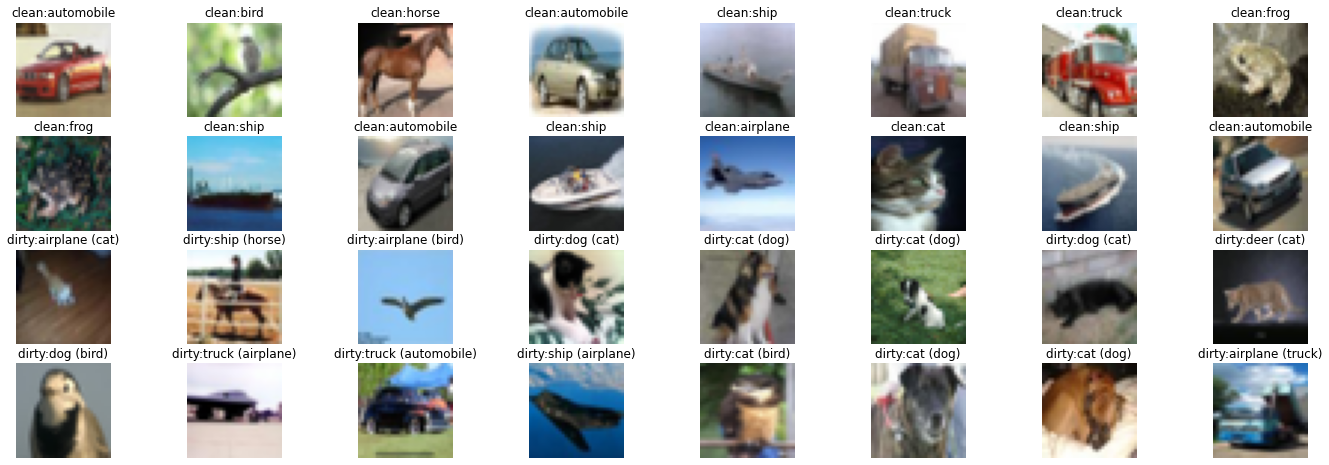

In [9]:
# dataset_names ["cifar10", "cifar100"]
# noise_modes ["sym", "asym", "openset", "dependent"]
# p any probability fro noise to 1 decimal, e.g.: 0.3, 0.6
# custom_noise if True, use custom noise (not by authors in GitHub), else from their GitHub
# make_new_custom_noise if True, make custom noise files

dataset_name = "cifar10"
noise_mode = "dependent"
p = 0.4
custom_noise = False
make_new_custom_noise = False

check_combos(dataset_name, noise_mode, custom_noise)

if dataset_name == "cifar10":
    means, stds = get_normalization_params(dataset_name=dataset_name, datapath=datapath)
    
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(means, stds)])

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means, stds)])

    train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=False, transform=test_transform)

elif dataset_name == "cifar100":
    means, stds = get_normalization_params(dataset_name=dataset_name, datapath=datapath)
    
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(means, stds)])

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means, stds)])

    train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=False, transform=test_transform)
else:
    raise Exceptiion

if make_new_custom_noise:
    make_inherent_label_noise(
        datapath=datapath, 
        dataset_name=dataset_name, 
        noise_mode=noise_mode, 
        p=p, 
        seed=123
    )

train_dataset, indices_noisy, noise_rules = add_inherent_label_noise(train_dataset, datapath, dataset_name, noise_mode, p, custom_noise)

print(f"dataset_name:{dataset_name}, noise_mode:{noise_mode}, noise_ratio:{indices_noisy.sum() / len(train_dataset.targets):.4f}")
print("noise_rules")
print(noise_rules)
print(indices_noisy)


###############

show_imgs(
    datapath=datapath, 
    dataset_name=dataset_name, 
    train_dataset=train_dataset,
    noise_mode=noise_mode,
    indices_noisy=indices_noisy
)

In [10]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_eval_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

### Questions

- openset: cifar10 and cifar100 have overlapping classes, still in openset noise it is disregarded. what if we accidentally swap a dog in cifar10 for a dog in cifar100?
- openset: swapping transformed images in cifar10 to un-transformed in cifar100?
- normalization parameters?